<a href="https://colab.research.google.com/github/GildasTaliah/Solutions_with_PyNoteBook/blob/main/PredictingWeatherTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREDICTING WEATHER TEMPERATURE**



As the climate changes, predicting the weather becomes ever more important for businesses. We have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, we will want to run some experiments to determine what the best approach is to predict the weather.

In this brief project, we will run experiments for different regression models predicting the mean temperature, using mainly `sklearn` Machine Learning (ML) package.


Note: This project is adapted from guided projects on DataCamp, completed as part of my journey to continue utilizing ML techniques in practical situations. The work presented here represents an extended and applied interpretation of the foundational materials.



We will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

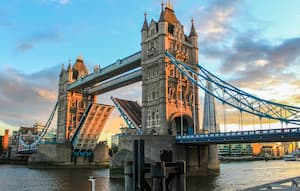

**What we are going to do**

We will usese machine learning models to predict the mean temperature in - London, England. Later, compute the model's root mean squared error (RMSE) metrics.

Our main goal is to build a model to predict "mean_temp" with a RMSE of 3 or less.

We will loop through to train their hyperparameters, and print respective RMSE scores.

Then lastly, interprete the results and highlight the model with lowest rmse.

In [48]:
# Run this cell to install mlflow
#!pip install mlflow

In [49]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
#import mlflow
#import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Linear model
from sklearn.linear_model import LinearRegression

# Tree models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# xgb
from xgboost import XGBRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Perform exploratory data analysis and data cleaning
weather.info()

# Convert date and extract information
weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
weather["year"] = weather["date"].dt.year
weather['month'] = weather['date'].dt.month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [50]:
# drop na values
#weather = weather.dropna()
# show head and tails
pd.concat([weather.head(3), weather.tail(3)])

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1979,1
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1979,1
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1979,1
15338,2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN,2020,12
15339,2020-12-30,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN,2020,12
15340,2020-12-31,7.0,1.3,34.0,1.5,-0.8,-3.1,0.0,100500.0,NaN,2020,12


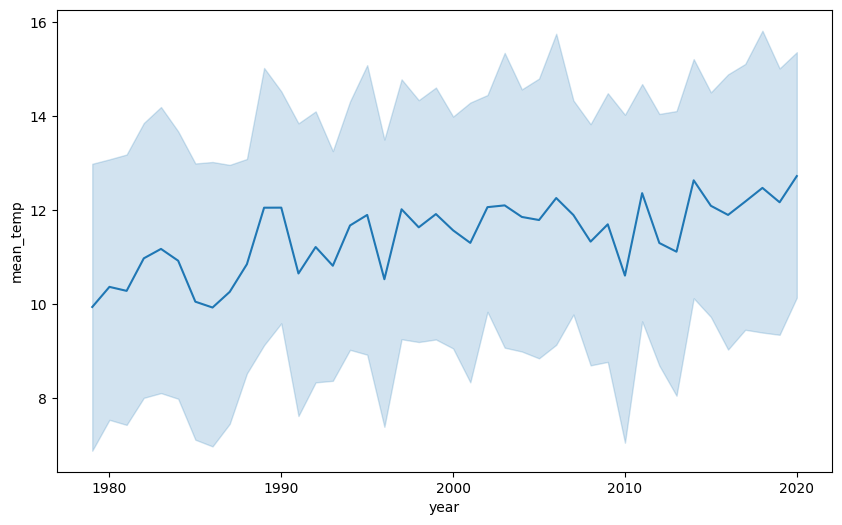

In [51]:
# Aggregate and calculate average metrics
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()

# Visualize relationships in the data
# fig size
plt.figure(figsize=(10, 6))
sns.lineplot(x="year", y="mean_temp", data=weather_per_month)
plt.show()

The mean temp across time, depicts a slightly upward trajectory. Temperatures in the 1980's where lower than temperatures in 2010's.

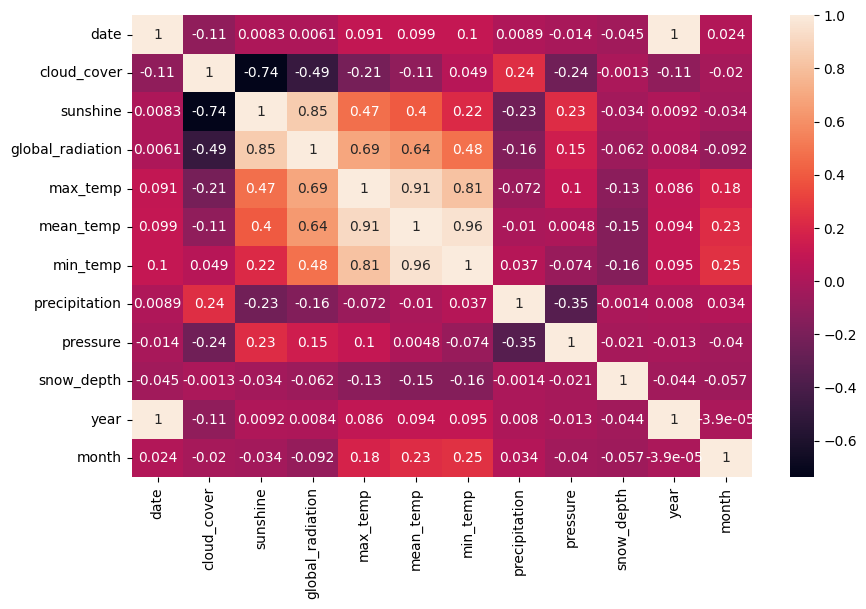

In [52]:
plt.figure(figsize=(10, 6))
sns.heatmap(weather.corr(), annot=True)
plt.show()

Global radiation is the most (positively) correlated variable to mean_temp - with corr greter than 0.75 and positive, it shares a strong positive correlation with mean_temp. Also the variables, sunshine and month shares a weak positive relationship, whilst cloud cover and  snow depth shares a weak positive rellationship. The values of the others are less than 0.1 in absolute value, thus the relationship is pretty much insignificant.

- Moreover it is worth noting correlation is not causation

In [53]:

# Choose features, define the target, and drop null values
feature_selection = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
target_var = 'mean_temp'
weather = weather.dropna(subset=['mean_temp'])

# Subset feature and target sets
X = weather[feature_selection]
y = weather[target_var]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Impute missing values
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test  = imputer.transform(X_test)

In [54]:
# Predict, evaluate, with metrics of our models
for idx, depth in enumerate([1, 2, 5, 7, 10]):
  #  run_name = f"run_{idx}"
   # with mlflow.start_run(run_name=run_name):
        # Create models
      lin_reg = LinearRegression().fit(X_train, y_train)
      tree_reg = DecisionTreeRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)
      forest_reg = RandomForestRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)
      xgb_reg = XGBRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)


      # Evaluate performance
      y_pred_lin_reg = lin_reg.predict(X_test)
      lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg) ** (1/2)
      y_pred_tree_reg = tree_reg.predict(X_test)
      tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg) ** (1/2)
      y_pred_forest_reg = forest_reg.predict(X_test)
      forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg) ** (1/2)
      y_pred_xgb_reg = xgb_reg.predict(X_test)
      xgb_reg_rmse = mean_squared_error(y_test, y_pred_xgb_reg) ** (1/2)

      # print depth
      print(f"Depth: {depth}")
      print(f"OLS Linear Regression RMSE   : {lin_reg_rmse:.4f}")
      print(f"Decision Tree Regression RMSE: {tree_reg_rmse:.4f}")
      print(f"Random Forest Regression RMSE: {forest_reg_rmse:.4f}")
      print(f"eXtremeGBoost Regression RMSE: {xgb_reg_rmse:.4f}")
      print("\n")

Depth: 1
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 4.7520
Random Forest Regression RMSE: 4.7053
eXtremeGBoost Regression RMSE: 2.9386


Depth: 2
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.9173
Random Forest Regression RMSE: 3.8485
eXtremeGBoost Regression RMSE: 2.8442


Depth: 5
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.0277
Random Forest Regression RMSE: 2.9695
eXtremeGBoost Regression RMSE: 2.8341


Depth: 7
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 2.9255
Random Forest Regression RMSE: 2.8425
eXtremeGBoost Regression RMSE: 2.9389


Depth: 10
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.0650
Random Forest Regression RMSE: 2.8105
eXtremeGBoost Regression RMSE: 3.0596




# **Scale Data**

In [55]:
# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)

In [56]:
# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate([1, 2, 5, 7, 10]):
  #  run_name = f"run_{idx}"
   # with mlflow.start_run(run_name=run_name):
        # Create models
      lin_reg = LinearRegression().fit(X_train, y_train)
      tree_reg = DecisionTreeRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)
      forest_reg = RandomForestRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)
      xgb_reg = XGBRegressor(random_state=75, max_depth=depth).fit(X_train, y_train)


      # Evaluate performance
      y_pred_lin_reg = lin_reg.predict(X_test)
      lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg) ** (1/2)
      y_pred_tree_reg = tree_reg.predict(X_test)
      tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg) ** (1/2)
      y_pred_forest_reg = forest_reg.predict(X_test)
      forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg) ** (1/2)
      y_pred_xgb_reg = xgb_reg.predict(X_test)
      xgb_reg_rmse = mean_squared_error(y_test, y_pred_xgb_reg) ** (1/2)

      # print depth
      print(f"Depth: {depth}")
      print(f"OLS Linear Regression RMSE   : {lin_reg_rmse:.4f}")
      print(f"Decision Tree Regression RMSE: {tree_reg_rmse:.4f}")
      print(f"Random Forest Regression RMSE: {forest_reg_rmse:.4f}")
      print(f"eXtremeGBoost Regression RMSE: {xgb_reg_rmse:.4f}")
      print("\n")

Depth: 1
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 4.7520
Random Forest Regression RMSE: 4.7053
eXtremeGBoost Regression RMSE: 2.9386


Depth: 2
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.9173
Random Forest Regression RMSE: 3.8485
eXtremeGBoost Regression RMSE: 2.8442


Depth: 5
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.0277
Random Forest Regression RMSE: 2.9696
eXtremeGBoost Regression RMSE: 2.8341


Depth: 7
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 2.9255
Random Forest Regression RMSE: 2.8423
eXtremeGBoost Regression RMSE: 2.9389


Depth: 10
OLS Linear Regression RMSE   : 3.8668
Decision Tree Regression RMSE: 3.0655
Random Forest Regression RMSE: 2.8094
eXtremeGBoost Regression RMSE: 3.0596




- Scaling the data did not have an impact.

- Random Forest with maximum depth of 10, scored the lowest (best) rmse at 2.80.  

- To improve rmse more, we could perform a much better feature selection. Additionally we can consider tuning more hyperparameters, tree depth for example.

In [ ]:
# The End !